# Creating Synthetic Load Time Series

PowNet is designed to work with time series data, facilitating seamless sensitivity analysis within its modeling framework. This example demonstrates how to generate multiple synthetic hourly load profile scenarios (specifically, 5 scenarios) using PowNet's time series capabilities. We will use a simplified system model, partly based on the 2023 Thai power system, as our case study. Data files for this case study, called "synthetic_timeseries", can be found [here](https://github.com/Critical-Infrastructure-Systems-Lab/PowNet/tree/master/model_library). Please download them to a folder on your local machine.

**Note:** PowNet requires the `pmdarima` package for advanced time series analysis. Ensure it is installed in your environment. If you use Conda, you can install it with: `conda install pmdarima`. This package is not included as a dependency in PowNet by default.

## Load Historical Load Data

We begin by loading the historical hourly load data for the relevant buses from a CSV file. This data serves as the basis for our time series model. The data is loaded into a pandas DataFrame, and the index is adjusted to start from 1, consistent with PowNet's indexing convention.

In [1]:
import os
import pandas as pd

from pownet.stochastic import DemandTSModel
from pownet.data_utils import get_datetime_index

load_filepath = os.path.join("..", "model_library", "synthetic_timeseries", "demand_export.csv")
demand_data = pd.read_csv(load_filepath)
demand_data.index += 1 # PowNet indexing starts at 1

demand_data.head()

,bus7,bus8,bus9,bus18,bus19
1,50.8887,23.4088,50.8887,50.8887,11.7044
2,50.0776,23.0357,50.0776,50.0776,11.5178
3,47.6247,21.9074,47.6247,47.6247,10.9537
4,45.8279,21.0809,45.8279,45.8279,10.5404
5,44.9296,20.6676,44.9296,44.9296,10.3338


## Prepare Data for Time Series Modeling

To model the overall system load behavior, we first calculate the total hourly demand by summing the load across all buses for each hour.

Next, we incorporate exogenous variables that significantly influence electricity demand, such as weather data (temperature 'temp', precipitation 'prcp') and calendar effects ('weekend'). This weather data is loaded from a separate CSV file.

Finally, we combine the total demand and exogenous variables into a single DataFrame and add a datetime index corresponding to the year 2023 to facilitate time series analysis. We will use this dataframe for time series analysis.

In [2]:
total_demand = demand_data.sum(axis=1)
total_demand.name = "total_demand"

# Exogenous variables that have significant impact on demand
exog_vars = ["temp", "prcp", "weekend"]
exog_data = pd.read_csv(
    os.path.join("..", "model_library", "synthetic_timeseries", "thailand_2023_weather.csv"), usecols=exog_vars
)

exog_data.index += 1 # PowNet indexing starts at 1
total_demand = pd.concat([total_demand, exog_data], axis=1)
total_demand["datetime"] = get_datetime_index(2023)

total_demand.head()

,total_demand,temp,prcp,weekend,datetime
1,187.7793,24.5,0.0,True,2023-01-01 00:00:00
2,184.7863,24.0,0.0,True,2023-01-01 01:00:00
3,175.7352,23.6,0.0,True,2023-01-01 02:00:00
4,169.1050,23.2,0.0,True,2023-01-01 03:00:00
5,165.7902,22.5,0.0,True,2023-01-01 04:00:00


## Initialize the Demand Time Series Model

The resulting DataFrame, containing the total demand time series and relevant exogenous variables, is used as input to initialize PowNet's `DemandTSModel` class.

In [3]:
demand_model = DemandTSModel()
demand_model.load_data(total_demand)

## Fit the SARIMAX Model

We now fit a Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors (SARIMAX) model to the prepared time series data. The `fit` method automates standard time series analysis steps, including potential transformations (like differencing for stationarity) and fitting the SARIMAX model itself.

We specify:
* `target_column`: The variable we want to model ('total_demand').
* `arima_order`: The non-seasonal (p, d, q) order of the ARIMA model.
* `seasonal_order`: The seasonal (P, D, Q, s) order, where 's' is the seasonal period (24 hours for daily seasonality).
* `exog_vars`: The list of exogenous variables to include in the model.

*Note: Fitting the model can take some time depending on the data size and model complexity.*

In [4]:
demand_model.fit(
    target_column="total_demand",
    arima_order=(1, 1, 1),
    seasonal_order=(1, 1, 0, 24),
    exog_vars=exog_vars,
)

## Analyze Model Residuals

After fitting the model, it's good practice to examine the residuals (the difference between the actual values and the model's predictions). Ideally, the residuals should resemble independent and identically distributed (i.i.d.) white noise, indicating that the model has captured the underlying patterns in the data well. The `plot_residuals` method helps visualize the distribution and autocorrelation of the residuals.

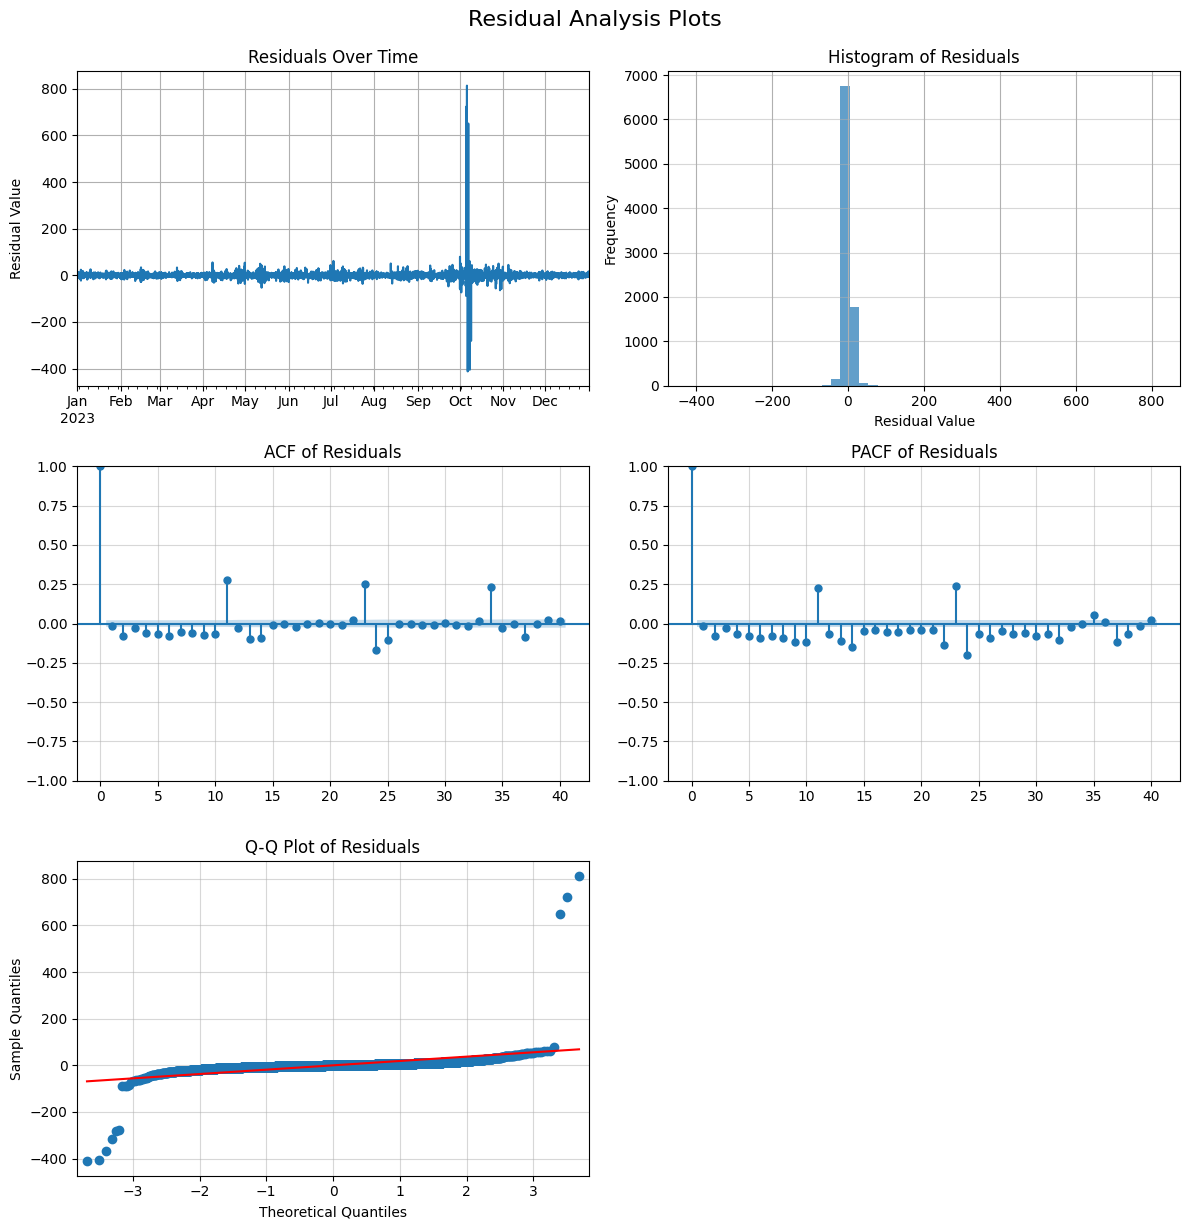

In [5]:
demand_model.plot_residuals(bins=50)

## Generate Synthetic Load Scenarios

Once satisfied with the fitted time series model, we can use it to generate synthetic load scenarios. We specify the desired number of scenarios (`num_scenarios`). For each scenario, the `get_synthetic` method simulates a new load time series based on the fitted SARIMAX model and the provided future exogenous data (in this case, we reuse the historical exogenous data for simulation). The generated scenarios capture the stochastic nature and patterns learned from the historical data.

In [6]:
exog_data.index = get_datetime_index(2023)
num_scenarios = 5
scenarios = pd.DataFrame(
    pd.NA, index=total_demand.index, columns=range(1, num_scenarios + 1)
)
for scenario_id in range(1, num_scenarios + 1):
    temp_series = demand_model.get_synthetic(exog_data=exog_data)
    temp_series = temp_series.reset_index(drop=True)
    temp_series.index += 1
    scenarios[scenario_id] = temp_series

## Visualize Synthetic Scenarios

Finally, we plot the generated synthetic time series scenarios, typically focusing on a shorter period (like the first 7 days) for better visualization, to compare their behavior and variability against each other and potentially the original data.

<Axes: title={'center': 'Synthetic Demand Scenarios'}, xlabel='hour', ylabel='Demand (MW)'>

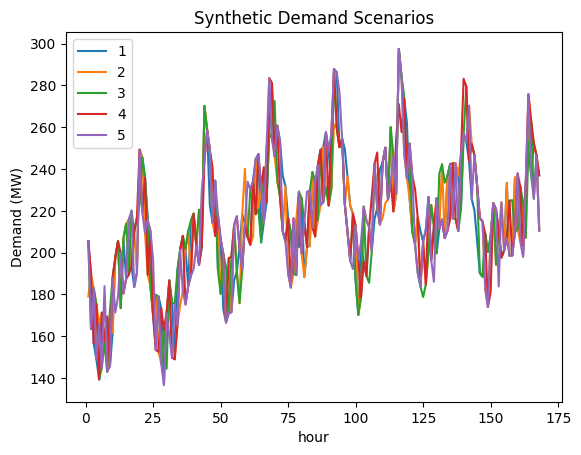

In [7]:
scenarios.head(24*7).plot(xlabel="hour", ylabel="Demand (MW)", title="Synthetic Demand Scenarios")